<a href="https://colab.research.google.com/github/soodeh-nilforoushan/Recurrent-Neural-Network/blob/main/5_TF_Autoregressive_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
!pip install -q tensorflow
import tensorflow as tf
print(tf.__version__)

2.12.0


In [32]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


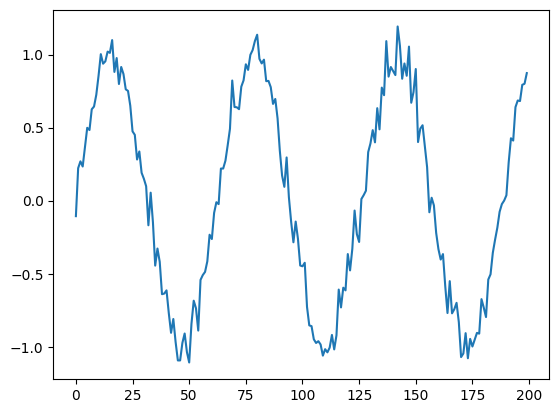

In [33]:
#make the original data set + add some noise
series=np.sin(0.1*np.arange(200)) + np.random.randn(200)*0.1
plt.plot(series)
plt.show()

In [34]:
#build the dataset
#lets see if we can use 10 past values to predict the next value
T=10
X=[]
Y=[]
for t in range(len(series)-T):
  x=series[t:t+T]
  X.append(x)
  y=series[t+T]
  Y.append(y)


X=np.array(X).reshape(-1,T)
Y=np.array(Y)
print(Y)
N=len(X)
print("X.shape", X.shape,"Y.shape", Y.shape)

[ 8.54679994e-01  1.00260855e+00  9.37402884e-01  9.53580427e-01
  1.02011969e+00  1.01146189e+00  1.09891369e+00  8.81081568e-01
  9.75927840e-01  7.98374505e-01  9.14905222e-01  8.66361519e-01
  7.61997035e-01  7.51080097e-01  6.50117522e-01  4.74179276e-01
  4.50515328e-01  2.81494506e-01  3.36718405e-01  1.90737404e-01
  1.49798574e-01  9.88593249e-02 -1.68555418e-01  5.45257302e-02
 -1.48164918e-01 -4.44635827e-01 -3.27901071e-01 -4.19072903e-01
 -6.40291400e-01 -6.35900765e-01 -6.14141254e-01 -7.69910586e-01
 -9.04554194e-01 -8.10105750e-01 -9.66582462e-01 -1.09369671e+00
 -1.09366654e+00 -9.73745550e-01 -9.09301455e-01 -1.03647914e+00
 -1.10765659e+00 -8.43929928e-01 -6.84654243e-01 -7.36526070e-01
 -8.89274486e-01 -5.42551492e-01 -5.09474304e-01 -4.87807411e-01
 -4.15518218e-01 -2.33233735e-01 -2.62718389e-01 -8.39103951e-02
 -1.07720550e-02 -2.36309935e-02  2.19739135e-01  2.19753600e-01
  2.73605151e-01  3.79865396e-01  4.92133742e-01  8.22212115e-01
  6.40870834e-01  6.39108

In [35]:
#try autoregressive linear model
i=Input(shape=(T,))
#one output and no activation function
x=Dense(1)(i)
model=Model(i,x)
model.compile(
    loss='mse',
    optimizer=Adam(lr=0.1),
)
#train the RNN
r=model.fit(
    X[:-N//2],Y[:-N//2], #You don't want to split up your data randomly, let's say using the scikit learn function. Train test split. This wouldn't make sense because a real forecasting model has to predict the future. It can't train on points within that future.Thus, our model trains only on the first half of the data set and validates on the second half. Now since sine w
    epochs=80,
    validation_data=(X[-N//2:],Y[-N//2:]),
            )


Epoch 1/80
3/3 [==============================] - 1s 137ms/step - loss: 1.2644 - val_loss: 1.2667
Epoch 2/80
3/3 [==============================] - 0s 24ms/step - loss: 1.2201 - val_loss: 1.2257
Epoch 3/80
3/3 [==============================] - 0s 27ms/step - loss: 1.1756 - val_loss: 1.1854
Epoch 4/80
3/3 [==============================] - 0s 37ms/step - loss: 1.1342 - val_loss: 1.1459
Epoch 5/80
3/3 [==============================] - 0s 37ms/step - loss: 1.0924 - val_loss: 1.1073
Epoch 6/80
3/3 [==============================] - 0s 35ms/step - loss: 1.0514 - val_loss: 1.0697
Epoch 7/80
3/3 [==============================] - 0s 36ms/step - loss: 1.0138 - val_loss: 1.0327
Epoch 8/80
3/3 [==============================] - 0s 31ms/step - loss: 0.9756 - val_loss: 0.9969
Epoch 9/80
3/3 [==============================] - 0s 33ms/step - loss: 0.9390 - val_loss: 0.9621
Epoch 10/80
3/3 [==============================] - 0s 36ms/step - loss: 0.9018 - val_loss: 0.9283
Epoch 11/80
3/3 [===========

When you use [:-5] as a slice, it means "from the beginning of the array up to (but not including) the last 5 elements." In other words, it will remove the last 5 rows from the two-dimensional array X.

select all rows starting from the 5th row from the end and going until the end of the array." In other words, it selects the last 5 rows of the two-dimensional array X

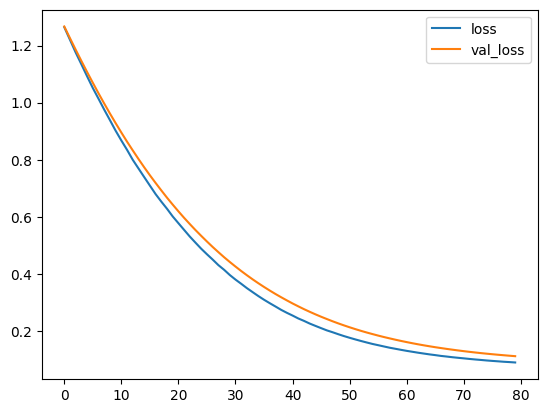

In [36]:
#plot loss per iteration
import matplotlib.pyplot as plt
plt.plot(r.history["loss"], label="loss")
plt.plot(r.history["val_loss"], label="val_loss")
plt.legend()

Because we have to make predictions sequentially. We can't do it all in one call of Model.predict like we did before.
Instead, we need to use a loop and call Model.predict only on the most recently generated sequence.

In [37]:
#wrong forecast using true targets
validation_target=Y[-N//2:] # first we assign the validation target variable, which is just the second half of Y.
validation_predictions=[]

#index of first validation input
i=-N//2
# print((X[i]))
# print((X[i].reshape(1,-1)))
while len(validation_predictions)<len(validation_target): #Once they are the same length, we know we are done because we've made all the predictions corresponding
  p=model.predict(X[i].reshape(1,-1))[0,0] #in general the model dot predict function returns an N by K output. If we have N samples and k output nodes.In this particular example, we happen to have one sample and one output node.So this returns a one by one two dimensional array.
  i+=1
  #update the predictions list with new predicted value
  validation_predictions.append(p)

#In this particular example, we happen to have one sample and one output node.
#So this returns a one by one two dimensional array.

1/1 [==============================] - 0s 22ms/step


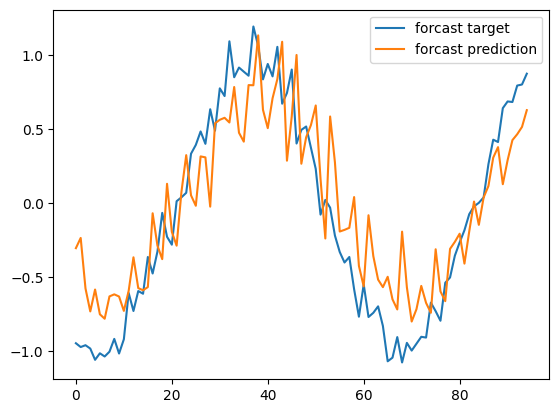

In [38]:
plt.plot(validation_target, label="forcast target")
plt.plot(validation_predictions,label="forcast prediction")
plt.legend()

In [39]:
#forecast future values(use only self-predictions for making future predictions)
validation_target=Y[-N//2:]
validation_predictions=[]

#But the problem was we shouldn't have been using the true input data to predict future values of the time series
#last train input
last_x=X[-N//2]

while len(validation_predictions)<len(validation_target):
  p=model.predict(X[i].reshape(1,-1))[0,0]
  i+=1

  #update the predictions list
  validation_predictions.append(p)

  #make the new input
  #shift or role by minus one means shift everything one spot to the left.
  last_x=np.roll(last_x,-1)
  #The leftmost value ends up looping back around to the right, but we replace it anyway with P. The latest prediction.
  last_x[-1]=p


1/1 [==============================] - 0s 23ms/step


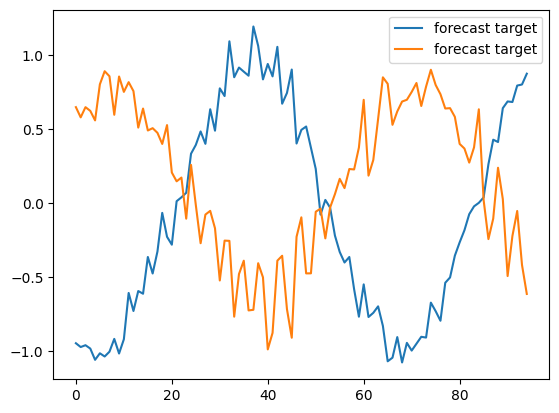

In [40]:
plt.plot(validation_target,label="forecast target")
plt.plot(validation_predictions,label="forecast target")
plt.legend()


As you can see, the results are no longer as good because of all that noise.

Interestingly, the model does learn that the pattern is periodic and that the true underlying function is smooth.